In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import cv2

In [2]:
def min_max_norm(image):
    ## Normalize the image pixels to the range [0,1]
    min_ = np.min(image)
    max_ = np.max(image)
    return (image - min_) / (max_ - min_)

## Loading images

In [3]:
# read image images
butterfly = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_png/butterfly.png')
seagull = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_png/seagull.png')
city = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_png/city.png')
print("butterfly shape",butterfly.shape)
print("seagull shape",seagull.shape)
print("city shape",city.shape)

butterfly shape (512, 512)
seagull shape (512, 512)
city shape (512, 512)


## Visualizing images

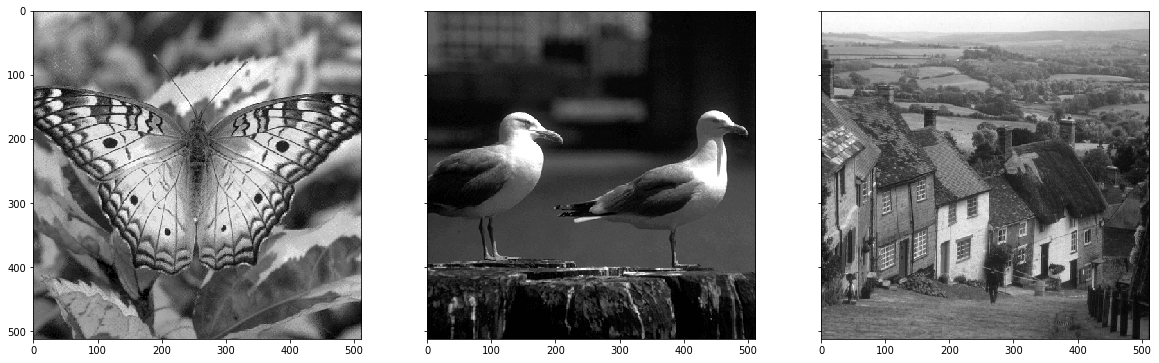

In [4]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(20,10))
ax1.imshow(butterfly, cmap='gray')
ax2.imshow(seagull, cmap='gray')
ax3.imshow(city, cmap='gray')
plt.show()

## High-pass Filtering

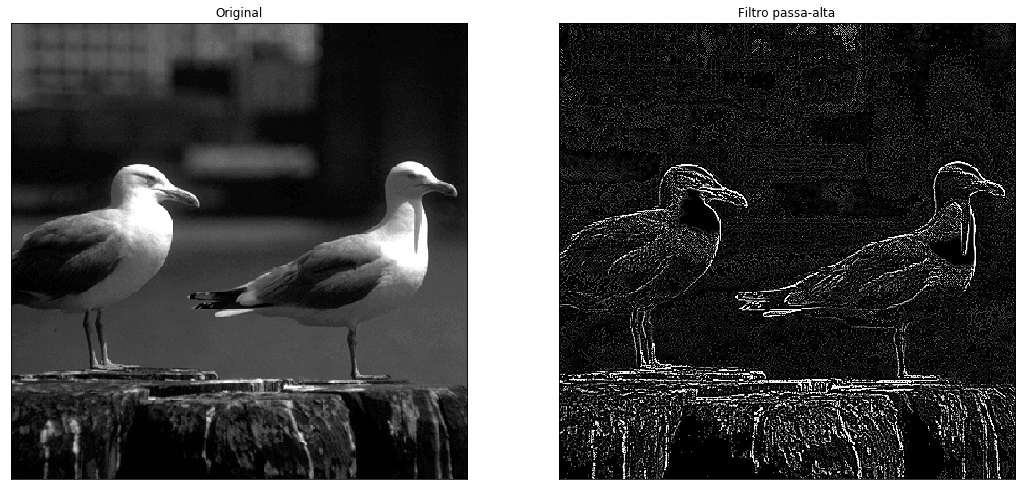

In [5]:
# Define the Laplacian of Gaussian kernel
kernel = np.array([[0, 0, -1, 0, 0],
                   [0, -1, -2, -1, 0],
                   [-1, -2, 16, -2, -1],
                   [0, -1, -2, -1, 0],
                   [0, 0, -1, 0, 0]])

# Apply the kernel to the image
# filter2D() performs correlation (not convolution).
# However, since the kernel is simetric, the 2 operations produces the same output
dst = cv2.filter2D(seagull,ddepth=cv2.CV_8U,kernel=kernel)

# Visualizing the result
plt.figure(figsize = (18,10))
plt.subplot(121),plt.imshow(seagull,cmap='gray'),plt.title('Original')
plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(dst,cmap='gray'),plt.title('Filtro passa-alta')
plt.xticks([]), plt.yticks([])
plt.show()

## Low pass Filtering

### Gaussian Filtering

In [6]:
# Define a Gaussian filter.
h2 = (1/16)*np.array([1,4,6,4,1])
print(h2)

[0.0625 0.25   0.375  0.25   0.0625]


In [7]:
# Perform convolution with linearly separable kernels
# This implementation runs in 2NM time instead of N^2M^2 for a classical convolution implementation
# Assuming a kernel NxN and an image MxM
def fast_conv2d(image, k1, k2):
    horizontal_conv = []
    for row in image.T:
        value = np.convolve(row, k1, mode='same')
        horizontal_conv.append(value)
    horizontal_conv = np.asarray(horizontal_conv)
    vertical_conv = []
    for row in horizontal_conv.T:
        value = np.convolve(row, k2, mode='same')
        vertical_conv.append(value)

    return np.asarray(vertical_conv)

In [8]:
# Since the Gaussian kernel is simetric and linearly separable, we can perform convolution 
# using fast_conv2d() for a faster implementation.
res = fast_conv2d(butterfly, h2, h2)

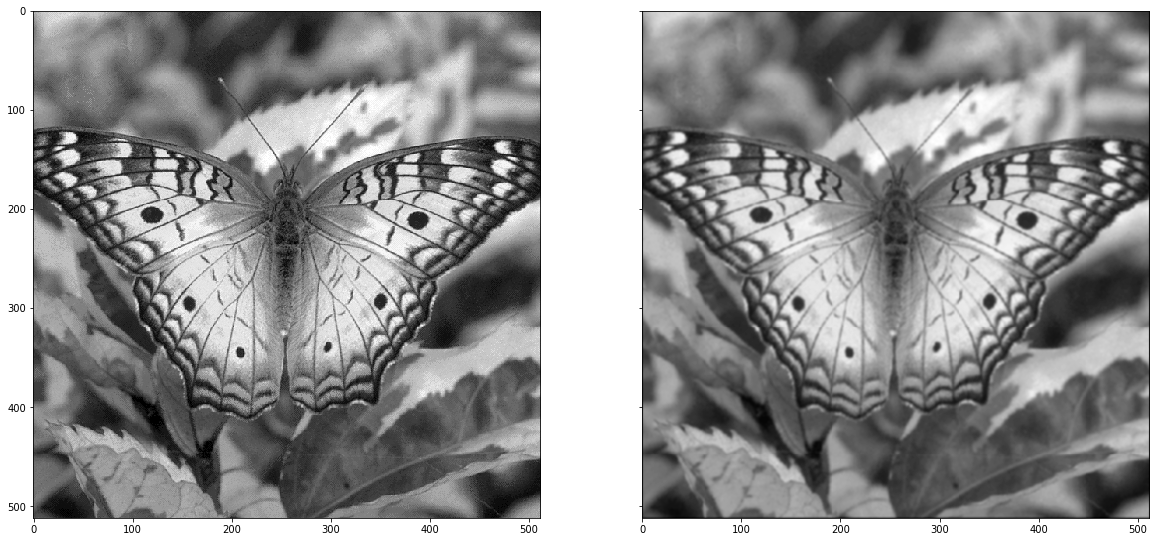

In [9]:
# Visualizing the results
fig, (ax1, ax2) = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(20,10))
ax1.imshow(min_max_norm(butterfly), cmap='gray')
ax2.imshow(res, cmap='gray')
plt.show()

## Sobel Filters

In [10]:
# first perform a vertical 1D convolution, then perform horizontal 1-D conv over the result of the first ope
Dx = fast_conv2d(butterfly, np.array([1,2,1]), np.array([1,0,-1]))
Dy = fast_conv2d(butterfly, np.array([1,0,-1]), np.array([1,2,1]))

In [11]:
from scipy.ndimage import convolve, binary_erosion, generate_binary_structure

In [12]:
# normalize the sober derivatives (this is just needed for visualization purposes)
Dx = (Dx + 4) / 8
Dy = (Dy + 4) / 8

# Calculate the magnitude of the gradients
magnitude = np.sqrt(np.square(Dx) + np.square(Dy))

# threashold the gradient
EROSION_SELEM = generate_binary_structure(2, 2)
mask = binary_erosion(magnitude, EROSION_SELEM, border_value=0)
magnitude = magnitude * mask

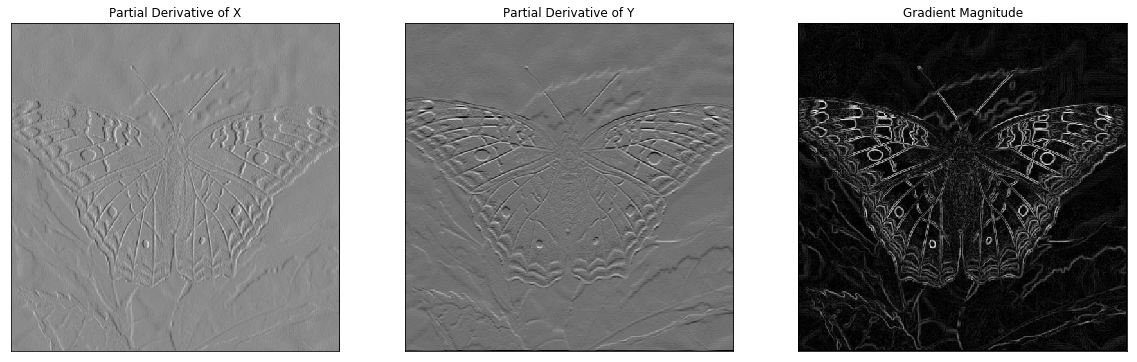

In [13]:
# checking the results
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(20,10))
ax1.imshow(min_max_norm(Dx), cmap='gray')
ax1.set_title('Partial Derivative of X'), plt.xticks([]), plt.yticks([])

ax2.imshow(min_max_norm(Dy), cmap='gray')
ax2.set_title('Partial Derivative of Y'), plt.xticks([]), plt.yticks([])

ax3.imshow(min_max_norm(magnitude),cmap='gray')
ax3.set_title('Gradient Magnitude'), plt.xticks([]), plt.yticks([])

plt.show()

## Convolution in the Frequency Domain

In [14]:
ncols, nrows = butterfly.shape

# Take the 2-dimensional DFT and centre the frequencies
ftimage = np.fft.fft2(butterfly)
ftimage = np.fft.fftshift(ftimage)
magnitude_spectrum = 20*np.log(np.abs(ftimage))

# The function computes and returns row matrix of a Gaussian filter coefficients
x = cv2.getGaussianKernel(ncols,sigma=3)
gaussian = x*x.T

# Take the FT of the Gaussian and center the frequencies
fft_gaussian = np.fft.fft2(gaussian)
fft_gaussian = np.fft.fftshift(fft_gaussian)
mag_spectrum = np.log(np.abs(fft_gaussian)+1)

# perform convolution on the frequency domain
ftimagep = ftimage * mag_spectrum
mag_spectrum_result = np.log(np.abs(ftimagep)+1)

# Finally, take the inverse transform and show the blurred image
imagep = np.fft.ifft2(ftimagep)

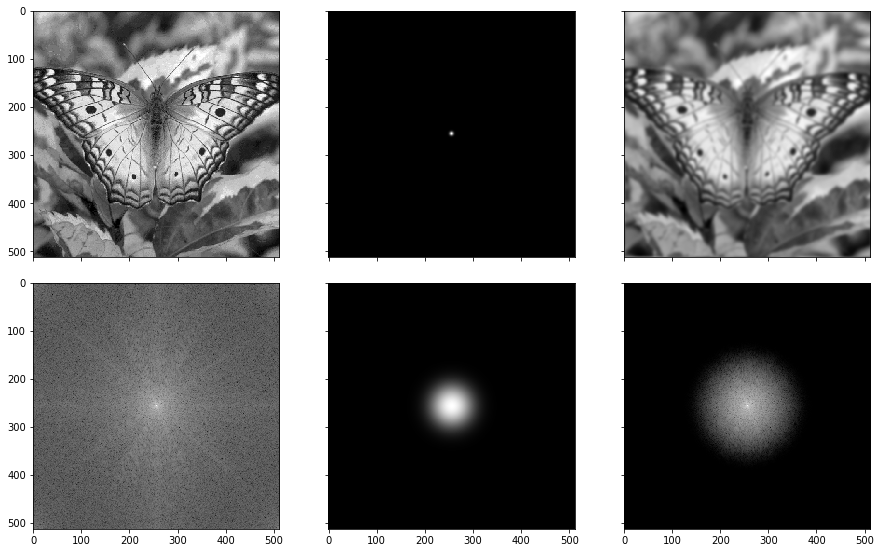

In [15]:
# Visualizing the results
fig, axs = plt.subplots(nrows=2, ncols=3, sharex=True, sharey=True, figsize=(15,10))

axs[0,0].imshow(min_max_norm(butterfly), cmap='gray')
axs[0,1].imshow(min_max_norm(gaussian), cmap='gray')
axs[0,2].imshow(np.abs(imagep), cmap='gray')

axs[1,0].imshow(np.abs(magnitude_spectrum), cmap='gray')
axs[1,1].imshow(np.abs(mag_spectrum), cmap='gray')
axs[1,2].imshow(np.abs(mag_spectrum_result), cmap='gray')
fig.subplots_adjust(hspace=0)
plt.show()